In [1]:
%pylab inline

from scipy.ndimage.filters import gaussian_filter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os

from styles.paper import *
from styles.colors import *
from styles.labels import *

from tools.plots import *
from tools.stats import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
par_lbs = [r"$M_*$", r"$\left<\log{t_*}\right>_M$", r"$\left<\log{t_*}\right>_L$",
           r"$\left<\log{Z_*/Z\odot}\right>_M$", r"$\left<\log{Z_*/Z\odot}\right>_L$", r"$A_V$"]

od = os.path.expandvars("$HOME/Documents/Publications/mejia+2016/")

In [3]:
def perturbation(xo, yo, x, y, R=0.1):
    idxs = arange(x.size, dtype=np.int)
    mask = (xo-x)**2 + (yo-y)**2<=R**2

    index = choice(idxs[mask])
    return index

In [4]:
#load SDSS catalog
table_obs = genfromtxt("../inputs/SDSS_catalog.txt", dtype=None, names=True)
#load whole SSAG
table_lib = genfromtxt("../inputs/tta_cb13/ssag/ssag_cb13_catalog.txt", dtype=None, names=True)
table_lib["log_Z_L_lib"] = log10(table_lib["log_Z_L_lib"])
table_lib["M_lib"] = table_lib["M_lib"]/(10**(-0.4*(table_lib["r"]-4.50)))
#load set3 sample
table_set = genfromtxt("../inputs/tta_cb13/ssag/set_catalog.txt", dtype=None, names=True)
table_set = table_set[table_set["Av_lib"]<=1.5]
table_set["M_lib"] = table_set["M_lib"]/(10**(-0.4*(table_set["r"]-4.50)))

xcolor_obs = (table_obs["modelMag_u"] - table_obs["modelMag_g"])[table_obs["z"]<0.03]
ycolor_obs = (table_obs["modelMag_g"] - table_obs["modelMag_r"])[table_obs["z"]<0.03]

xcolor_lib = table_lib["u"] - table_lib["g"]
ycolor_lib = table_lib["g"] - table_lib["r"]

xcolor_set = table_set["u"] - table_set["g"]
ycolor_set = table_set["g"] - table_set["r"]

In [5]:
table_set["M_lib"].min(), table_set["M_lib"].max()

(0.72621663903760236, 19.011293232712696)

In [6]:
labels = [r"$M_*/L_{*,r}$ ($\text{M}_\odot/\text{L}_\odot$)", r"$\left<\log{t_*/\text{yr}}\right>_L$", r"$\log{Z_*/\text{Z}_\odot}$", r"$A_V$"]
limits = [(0.7, 19.0), (8, 10.5), (-1.1, 0.45), (0, 1.7)]
fields = ["M_lib", "log_t_L_lib", "log_Z_L_lib", "Av_lib"]
xi, xc, xe = [], [], []
nb = 15
for i in xrange(100):
    ind = array([perturbation(x, y, xcolor_lib, ycolor_lib) for x, y in zip(xcolor_set, ycolor_set)])
    xi.append(ind)
    
    fcounts, fcenter = [], []
    for j in xrange(len(fields)):
        counts, edges = histogram(table_lib[fields[j]][ind], nb, range=limits[j])
        fcounts.append(counts)
        fcenter.append(edges[:-1])
    xc.append(fcounts)

xi = array(xi)
xc = array(xc)
xe = array(fcenter)

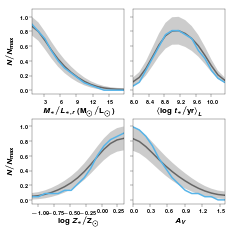

In [7]:
fig, axs = subplots(2, 2, figsize=(3.3, 3.3), sharey=True)
axs = axs.ravel()

mean_counts = xc.mean(axis=0)
sigm_counts = xc.std(axis=0)

for i in xrange(axs.size):
    n = histogram(table_set[fields[i]], nb, range=limits[i])
    
    ymin = gaussian_filter(mean_counts[i]-sigm_counts[i], 2)
    ymax = gaussian_filter(mean_counts[i]+sigm_counts[i], 2)
    ylib = gaussian_filter(mean_counts[i], 2)
    yset = gaussian_filter(n[0], 2)
    
    axs[i].fill_between(xe[i], ymin/ymax.max(), ymax/ymax.max(), lw=0, facecolor="0.8")
    axs[i].plot(xe[i], ylib/ymax.max(), "-", lw=1.5, color="0.4", solid_joinstyle="round")
    axs[i].plot(xe[i], yset/ymax.max(), "-", lw=1.5, color=samples["cold"], solid_joinstyle="round")

    axs[i].set_xlabel(r"\bf "+labels[i])
    axs[i].set_xlim(n[1][[0,-2]])
    axs[i].xaxis.set_major_locator(MaxNLocator(nbins=6))

ylim(-0.05, 1.1)
axs[0].set_ylabel(r"\bf $N/N_\text{max}$")
axs[2].set_ylabel(r"\bf $N/N_\text{max}$")

tight_layout()
subplots_adjust(hspace=0.3, wspace=0.1)

savefig("{}mock_sample_robustness".format(od))

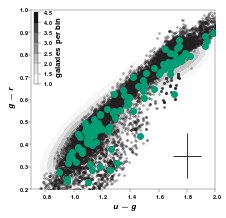

In [8]:
xcolor_cum = append(xcolor_set, xcolor_lib[xi])
ycolor_cum = append(ycolor_set, ycolor_lib[xi])

xlm = array((0.7, 2.0))
ylm = array((0.2, 1.0))
axs = subplot(111, xlim=xlm, ylim=ylm)
ins = inset_axes(axs, width="2.5%", height="40%", loc=2)

axs.set_xlabel(r"\bf $u-g$")
axs.set_ylabel(r"\bf $g-r$")

nx, xini, xfin, bsx = nbins(xcolor_obs)
ny, yini, yfin, bsy = nbins(ycolor_obs)

H, xedges, yedges = histogram2d(xcolor_obs, ycolor_obs, bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=2)

cont = axs.contourf(xedges[:- 1], yedges[:- 1], H.T, cmap=cm.Greys, levels=np.arange(1, 5, 0.5))
cb = colorbar(cont, cax=ins)
cb.set_label(r"\bf galaxies per bin")

axs.scatter(xcolor_cum[120:], ycolor_cum[120:], marker="o", lw=0.0, c=samples["dark"], s=7, alpha=0.4)
axs.scatter(xcolor_cum[:120], ycolor_cum[:120], marker="o", lw=0.0, c=samples["warm"])

axs.errorbar([1.8], [0.35], 0.1, 0.1, color="0.2", ecolor="0.2")

ins.tick_params(right=True, left=False, direction="out", labelright="on", labelleft="off")
ins.yaxis.set_label_position("right")

savefig("{}sample_robustness".format("img/"))